# Mass Fitting

We have to perform mass fitting based on this approach
* 1D mass fitting: One dimension fitting can be perform either on diphoton mass, dibjet mass, or reduced mass. (p.s.  Fitting reduced mass should be a task
* 2D mass fitting: two dimensions fitting, taking two mass at a time. It could be diphoton & dibjet, diphoton & reduced mass, or dibjet & reduced mass.
* 3D mass fitting: most challenging one including all of the masses.

fitting fucntions are:
- [ ] Bernstein polynomials
- [ ] Exponential functions
- [ ] Power law functions
- [ ] Landau distributions
- [ ] Kolmogorov distribution(https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test#Kolmogorov_distribution)
- [ ] Binned Likelihoods with Templates
- [ ] Johnson Distributions
- [ ] Spline Functions
- [ ]  Double-Sided Crystal Ball Function
- [ ] Generalized Hyperbolic Functions
- [ ] RooFit-specific PDFs
- [ ] Voigt Profile
- [ ] Laurent Series
- [ ] Chebyshev Polynomials

from Lata's paper, 
- For signal modeling, categorized events are fitted with a product of two parametric 
    - signal models: a sum of Gaussian distributions for mγ γ and a double-sided Crystal Ball (CB) function or the sum of a CB and a Gaussian function for mjj. The mγ γ distribution is parametrized using the sum of up to five Gaussian functions without any constraint to have a common mean.
    
 -  for the ggF H and VBF H:
     - the mjj distribution is modeled with a Bernstein polynomial; for VH production, a CB function is used to model the distribution of the hadronic decays of vector bosons;
for ttH, where the two b jets are produced from a top quark decay, a Gaussian function
with a mean value of 120GeV is used. These backgrounds are negligible for mX >550 GeV,
therefore, they are absorbed within the nonresonant background model coming from data
to simplify the signal extraction procedure.
The nonresonant background model is extracted from data using the discrete profiling
method described in refs. [68, 81]. This method makes use of polynomial and exponential
functions to decide the analytic functions to fit the background mγ γ and mjj distributions. It
estimates the systematic uncertainty associated with these functions and treats the choice of
background function as a discrete nuisance parameter in the likelihood fit to the data. For
background modeling, the fit functions are optimized on data where the events from the signal
region with 115 < mγ γ < 135 GeV are not taken into account.

## Crystal ball function

/tmp/sraj/ipykernel_1249569/2780316219.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_1249569/2780316219.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


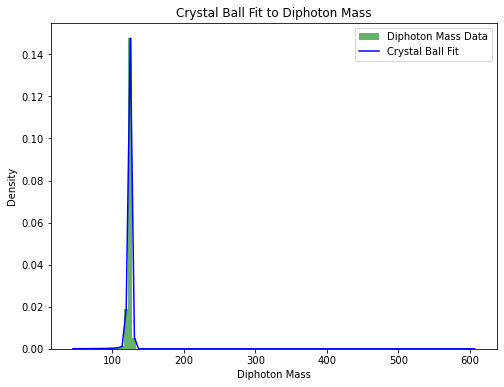

Fitted Crystal Ball Parameters: alpha=2.476, n=1.146, mu=124.438, sigma=2.474


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf  # Import the error function
import uproot
import awkward as ak
from vector import Array as awk

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma):
    """
    Crystal Ball PDF.
    :param x: Input data points
    :param alpha: Tail parameter
    :param n: Tail parameter
    :param mu: Mean of the Gaussian
    :param sigma: Standard deviation of the Gaussian
    :return: PDF values
    """
    A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)
    B = n / abs(alpha) - abs(alpha)
    C = (n / abs(alpha)) * (1 / (n - 1)) * np.exp(-alpha**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))  # Use scipy.special.erf
    
    N = 1 / (sigma * (C + D))
    
    z = (x - mu) / sigma
    pdf = np.where(
        z > -alpha,
        N * np.exp(-0.5 * z**2),
        N * A * (B - z)**-n
    )
    return pdf

# Define the fitting function
def fit_crystalball(data, bins):
    """
    Fit data to the Crystal Ball function.
    :param data: Input data to be fitted
    :param bins: Bin edges for the histogram
    :return: Fitted parameters and bin centers
    """
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guesses for the parameters: alpha, n, mu, sigma
    initial_params = [1.5, 5, np.mean(data), np.std(data)]
    
    # Fit the histogram data
    params, _ = curve_fit(crystalball_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], p0=initial_params)
    return params, bin_centers

# Path to the ROOT file and tree
file_path = "../../../output_root/v1_v2_comparison/NMSSM_X400_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)

# Extract diphoton mass
diphoton_mass = diphoton_.mass

# Convert `diphoton_mass` to NumPy array
diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Define histogram bins
bins = np.linspace(min(diphoton_mass_np), max(diphoton_mass_np), 100)

# Fit the Crystal Ball function to diphoton mass
params, bin_centers = fit_crystalball(diphoton_mass_np, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(diphoton_mass_np, bins=bins, density=True, alpha=0.6, color="g", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")
plt.xlabel("Diphoton Mass")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass")
plt.legend()
plt.show()

# Print fit parameters
print(f"Fitted Crystal Ball Parameters: alpha={params[0]:.3f}, n={params[1]:.3f}, mu={params[2]:.3f}, sigma={params[3]:.3f}")


/tmp/sraj/ipykernel_1249569/2780316219.py:31: RuntimeWarning: invalid value encountered in power
  N * A * (B - z)**-n
/tmp/sraj/ipykernel_1249569/2780316219.py:20: RuntimeWarning: invalid value encountered in double_scalars
  A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)


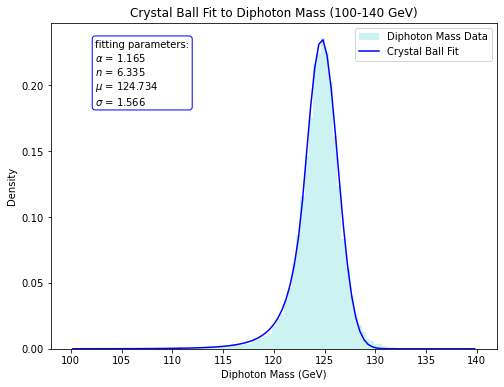

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the desired mass range
mass_min = 100
mass_max = 140

# Filter diphoton_mass within the desired range
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define histogram bins within the reduced range
bins = np.linspace(mass_min, mass_max, 100)

# Fit the Crystal Ball function to the filtered data
params, bin_centers = fit_crystalball(filtered_mass, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Prepare the parameter text for the box
param_text = (
    f"fitting parameters:\n"
    f"$\\alpha$ = {params[0]:.3f}\n"
    f"$n$ = {params[1]:.3f}\n"
    f"$\\mu$ = {params[2]:.3f}\n"
    f"$\\sigma$ = {params[3]:.3f}"
)

# Plot the histogram and Crystal Ball fit
plt.figure(figsize=(8, 6))
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.2, color="c", label="Diphoton Mass Data")
plt.plot(bin_centers, fitted_curve_cb, "b-", label="Crystal Ball Fit")

# Add parameter box to the plot
plt.gca().text(
    0.10, 0.95, param_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="white")
)

# Add labels and legend
plt.xlabel("Diphoton Mass (GeV)")
plt.ylabel("Density")
plt.title("Crystal Ball Fit to Diphoton Mass (100-140 GeV)")
plt.legend()  # Ensure legend is added before saving the figure

# Save the plot
output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}CrystalBall_Fit_Diphoton_mass.png")
plt.savefig(f"{output_dir}CrystalBall_Fit_Diphoton_mass.pdf")
plt.show()


/tmp/sraj/ipykernel_34415/949275205.py:29: RuntimeWarning: invalid value encountered in power
  N * A * (B - z) ** -n


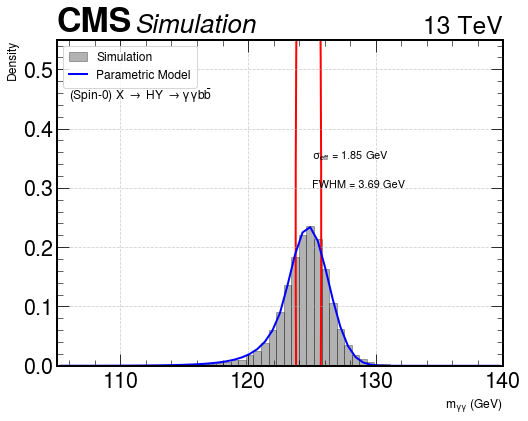

In [10]:
# improved plotting for the fitting

import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
from scipy.special import erf
import uproot
import awkward as ak
from vector import Array as awk
import matplotlib.patches as patches

# Use CMS style
hep.style.use("CMS")

# Define the Crystal Ball PDF
def crystalball_pdf(x, alpha, n, mu, sigma):
    if alpha <= 0 or n <= 1:
        return np.zeros_like(x)  # Return zeros to avoid NaN issues
    
    A = (n / abs(alpha)) ** n * np.exp(-alpha**2 / 2)
    B = n / abs(alpha) - abs(alpha)
    C = (n / abs(alpha)) * (1 / (n - 1)) * np.exp(-alpha**2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(alpha / np.sqrt(2)))
    
    N = 1 / (sigma * (C + D))
    z = (x - mu) / sigma
    pdf = np.where(
        z > -alpha,
        N * np.exp(-0.5 * z**2),
        N * A * (B - z) ** -n
    )
    return pdf

# Define fitting function
def fit_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    initial_params = [1.5, 5, np.mean(data), np.std(data)]

    try:
        params, _ = curve_fit(
            crystalball_pdf, bin_centers, np.histogram(data, bins=bins, density=True)[0], 
            p0=initial_params, bounds=([0.1, 1.1, np.min(data), 0.1], [5, 50, np.max(data), 10])
        )
    except RuntimeError:
        print("Fit failed, using initial parameters")
        params = initial_params  # Use initial parameters if fit fails

    return params, bin_centers

# Load Data (ROOT File)
file_path = "../../../output_root/v1_v2_comparison/NMSSM_X400_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

with uproot.open(file_path) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Compute Diphoton Mass
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    return lvec_1 + lvec_2

diphoton_ = lVector(
    lead_pho_pt, lead_pho_eta, lead_pho_phi, sublead_pho_pt, sublead_pho_eta, sublead_pho_phi
)

diphoton_mass_np = ak.to_numpy(diphoton_.mass)

# Define mass range
mass_min, mass_max = 105, 140
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]
bins = np.linspace(mass_min, mass_max, 60)

# Fit the Crystal Ball function
params, bin_centers = fit_crystalball(filtered_mass, bins)
fitted_curve_cb = crystalball_pdf(bin_centers, *params)

# Compute FWHM
mu, sigma = params[2], params[3]
FWHM = 2.35 * sigma
sigma_eff = sigma * np.sqrt(2 * np.log(2))

# Plotting
plt.figure(figsize=(8, 6))

# Histogram
plt.hist(filtered_mass, bins=bins, density=True, alpha=0.3, color="black", edgecolor="black", label="Simulation")

# Crystal Ball Fit Curve
plt.plot(bin_centers, fitted_curve_cb, "b-", linewidth=2, label="Parametric Model")

# Apply CMS Style
hep.cms.text("Simulation", loc=0)  
hep.cms.lumitext("13 TeV")  # Fixed: Removed 'loc' argument

# Add physics process label
plt.text(106, 0.45, r"(Spin-0) X $\to$ HY $\to \gamma\gamma b\bar{b}$", fontsize=12)

# Add Effective Width and FWHM Texts (Fixed Formatting)
plt.text(125, 0.35, fr"$\sigma_{{\mathrm{{eff}}}}$ = {sigma_eff:.2f} GeV", fontsize=11)
plt.text(125, 0.30, fr"FWHM = {FWHM:.2f} GeV", fontsize=11)

# Axes Labels
plt.xlabel(r"$m_{\gamma\gamma}$ (GeV)", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Set Limits
plt.xlim(mass_min, mass_max)
plt.ylim(0, 0.55)

# Grid and Legend
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(frameon=True, loc="upper left", fontsize=12)

# Define the circle parameters
circle_x = mu  # Center at fitted peak position
circle_y = max(fitted_curve_cb)  # Peak height
circle_radius = 1.0  # Adjust size for better visibility

# Create the circle patch
circle = patches.Circle((circle_x, circle_y), circle_radius, color='red', fill=False, linewidth=2)

# Ensure it's added AFTER plt.figure()
plt.gca().add_patch(circle)
# Save the Figure
output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
# plt.savefig(f"{output_dir}CMS_Style_Fit_mplhep.png", dpi=300)
# plt.savefig(f"{output_dir}CMS_Style_Fit_mplhep.pdf", dpi=300)

plt.show()


# Dibjet($M_{jj}$)


In [3]:
import uproot
import awkward as ak

# Path to the ROOT file and tree
file_path = "../../../output_root/v1_v2_comparison/NMSSM_X400_Y60.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"

# Load the ROOT file and extract variables
with uproot.open(file_path) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")

# Now you have all the required variables extracted directly from the ROOT file
# You can use these variables for further computations or analysis


# Double Side Crystal ball

/tmp/sraj/ipykernel_1249569/2378819391.py:20: RuntimeWarning: invalid value encountered in power
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1249569/2378819391.py:13: RuntimeWarning: invalid value encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1249569/2378819391.py:23: RuntimeWarning: invalid value encountered in power
  A2 * (B2 + z) ** -n2,
/tmp/sraj/ipykernel_1249569/2378819391.py:13: RuntimeWarning: overflow encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1249569/2378819391.py:20: RuntimeWarning: invalid value encountered in multiply
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1249569/2378819391.py:27: RuntimeWarning: invalid value encountered in divide
  return pdf / np.trapz(pdf, x)


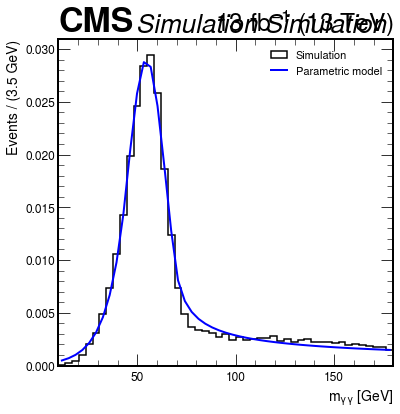

Fitted DSCB Parameters:
  Alpha1 = 1.084,  N1 = 144.973
  Alpha2 = 1.468,  N2 = 0.558
  Mu = 54.668,  Sigma = 9.820
Chi-squared / dof: 0.00


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep  # Import mplhep for CMS style
from scipy.optimize import curve_fit
import awkward as ak

# Apply CMS Style
hep.style.use("CMS")

# Define the Double-Sided Crystal Ball function
def double_sided_crystalball(x, alpha1, n1, alpha2, n2, mu, sigma):
    z = (x - mu) / sigma
    A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
    A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
    B1 = n1 / abs(alpha1) - abs(alpha1)
    B2 = n2 / abs(alpha2) - abs(alpha2)

    pdf = np.where(
        z < -alpha1,
        A1 * (B1 - z) ** -n1,
        np.where(
            z > alpha2,
            A2 * (B2 + z) ** -n2,
            np.exp(-0.5 * z ** 2),
        ),
    )
    return pdf / np.trapz(pdf, x)

# Define fitting function
def fit_double_sided_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist_vals, _ = np.histogram(data, bins=bins, density=True)

    # Initial parameter guesses
    initial_params = [1.5, 5, 1.5, 5, np.mean(data), np.std(data)]
    
    # Fit data
    params, _ = curve_fit(double_sided_crystalball, bin_centers, hist_vals, p0=initial_params)
    return params, bin_centers

# Load Diphoton Mass Data
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define mass range
mass_min, mass_max = 10, 180
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define bins
bins = np.linspace(mass_min, mass_max, 50)

# Perform fit
params_dscb, bin_centers = fit_double_sided_crystalball(filtered_mass, bins)
fitted_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Compute chi-squared
hist_vals, _ = np.histogram(filtered_mass, bins=bins, density=True)
errors = np.sqrt(hist_vals)  # Poisson errors
errors[errors == 0] = 1  # Avoid division by zero

chi2_val = np.sum(((hist_vals - fitted_dscb) / errors) ** 2)
dof = len(bin_centers) - len(params_dscb)  
chi2_dscb = chi2_val / dof if dof > 0 else 0  # Avoid division by zero

# Create CMS-Style Plot
plt.figure(figsize=(6, 6))

# Histogram (No error bars)
plt.hist(filtered_mass, bins=bins, density=True, histtype='step', color="black", linewidth=1.5, label="Simulation")

# Fit curve
plt.plot(bin_centers, fitted_dscb, "b-", linewidth=2, label="Parametric model")

# Apply CMS Label
hep.cms.label("Simulation", data=False, lumi=13, loc=0)

# Labels
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.ylabel(r"Events / (%.1f GeV)" % (bins[1] - bins[0]), fontsize=14)

# Legend
plt.legend(fontsize=11, loc="upper right", frameon=False)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(mass_min, mass_max)

plt.show()

# Print Fit Parameters
print(f"Fitted DSCB Parameters:")
print(f"  Alpha1 = {params_dscb[0]:.3f},  N1 = {params_dscb[1]:.3f}")
print(f"  Alpha2 = {params_dscb[2]:.3f},  N2 = {params_dscb[3]:.3f}")
print(f"  Mu = {params_dscb[4]:.3f},  Sigma = {params_dscb[5]:.3f}")
print(f"Chi-squared / dof: {chi2_dscb:.2f}")


/tmp/sraj/ipykernel_1249569/4011563789.py:20: RuntimeWarning: invalid value encountered in power
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1249569/4011563789.py:13: RuntimeWarning: invalid value encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1249569/4011563789.py:23: RuntimeWarning: invalid value encountered in power
  A2 * (B2 + z) ** -n2,
/tmp/sraj/ipykernel_1249569/4011563789.py:13: RuntimeWarning: overflow encountered in double_scalars
  A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
/tmp/sraj/ipykernel_1249569/4011563789.py:20: RuntimeWarning: invalid value encountered in multiply
  A1 * (B1 - z) ** -n1,
/tmp/sraj/ipykernel_1249569/4011563789.py:27: RuntimeWarning: invalid value encountered in divide
  return pdf / np.trapz(pdf, x)


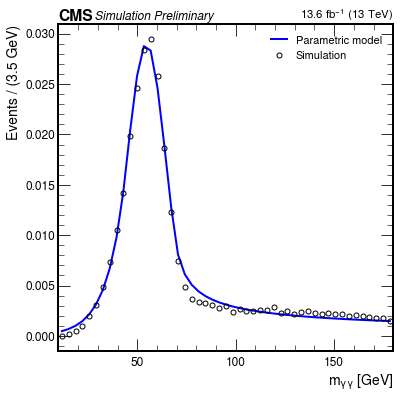

Fitted DSCB Parameters:
  Alpha1 = 1.084,  N1 = 144.973
  Alpha2 = 1.468,  N2 = 0.558
  Mu = 54.668,  Sigma = 9.820
Chi-squared / dof: 0.00


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep  # CMS-style plotting
from scipy.optimize import curve_fit
import awkward as ak

# Apply CMS Style
hep.style.use("CMS")

# Define the Double-Sided Crystal Ball function
def double_sided_crystalball(x, alpha1, n1, alpha2, n2, mu, sigma):
    z = (x - mu) / sigma
    A1 = (n1 / abs(alpha1)) ** n1 * np.exp(-alpha1 ** 2 / 2)
    A2 = (n2 / abs(alpha2)) ** n2 * np.exp(-alpha2 ** 2 / 2)
    B1 = n1 / abs(alpha1) - abs(alpha1)
    B2 = n2 / abs(alpha2) - abs(alpha2)

    pdf = np.where(
        z < -alpha1,
        A1 * (B1 - z) ** -n1,
        np.where(
            z > alpha2,
            A2 * (B2 + z) ** -n2,
            np.exp(-0.5 * z ** 2),
        ),
    )
    return pdf / np.trapz(pdf, x)

# Define fitting function
def fit_double_sided_crystalball(data, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    hist_vals, _ = np.histogram(data, bins=bins, density=True)

    # Initial parameter guesses
    initial_params = [1.5, 5, 1.5, 5, np.mean(data), np.std(data)]
    
    # Fit data
    params, _ = curve_fit(double_sided_crystalball, bin_centers, hist_vals, p0=initial_params)
    return params, bin_centers

# Load Diphoton Mass Data
diphoton_mass_np = ak.to_numpy(dijet_mass)

# Define mass range
mass_min, mass_max = 10, 180
filtered_mass = diphoton_mass_np[(diphoton_mass_np >= mass_min) & (diphoton_mass_np <= mass_max)]

# Define bins
bins = np.linspace(mass_min, mass_max, 50)

# Perform fit
params_dscb, bin_centers = fit_double_sided_crystalball(filtered_mass, bins)
fitted_dscb = double_sided_crystalball(bin_centers, *params_dscb)

# Compute chi-squared
hist_vals, _ = np.histogram(filtered_mass, bins=bins, density=True)
errors = np.sqrt(hist_vals)  # Poisson errors
errors[errors == 0] = 1  # Avoid division by zero

chi2_val = np.sum(((hist_vals - fitted_dscb) / errors) ** 2)
dof = len(bin_centers) - len(params_dscb)  
chi2_dscb = chi2_val / dof if dof > 0 else 0  # Avoid division by zero

# Create CMS-Style Plot
plt.figure(figsize=(6, 6))

# Plot simulation points (black circles)
plt.errorbar(bin_centers, hist_vals, fmt="o", color="black", markersize=5, label="Simulation",markerfacecolor='none')

# Plot the parametric model (smooth blue curve)
plt.plot(bin_centers, fitted_dscb, "b-", linewidth=2, label="Parametric model")

# Apply CMS Label
# Apply CMS Label with "Preliminary"
hep.cms.label(data=False, lumi=13.6, loc=0, fontsize=12, label="Preliminary")

# Labels
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.ylabel(r"Events / (%.1f GeV)" % (bins[1] - bins[0]), fontsize=14)

# Legend
plt.legend(fontsize=11, loc="upper right", frameon=False)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(mass_min, mass_max)

# # Add fit parameters to the plot
# param_text = (
#     rf"$\alpha_1 = {params_dscb[0]:.2f}$" + "\n" +
#     rf"$n_1 = {params_dscb[1]:.2f}$" + "\n" +
#     rf"$\alpha_2 = {params_dscb[2]:.2f}$" + "\n" +
#     rf"$n_2 = {params_dscb[3]:.2f}$" + "\n" +
#     rf"$\mu = {params_dscb[4]:.2f}$ GeV" + "\n" +
#     rf"$\sigma = {params_dscb[5]:.2f}$ GeV" + "\n" +
#     rf"$\chi^2/\mathrm{{dof}} = {chi2_dscb:.2f}$"
# )

# # Place the text in the upper left
# plt.text(0.05, 0.75, param_text, transform=plt.gca().transAxes, 
#          fontsize=12, verticalalignment='top', horizontalalignment = 'right',
#          bbox=dict(boxstyle="round,pad=0.3", 
#                    edgecolor="black", facecolor="white"))

output_dir = "/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/"
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass.png")
plt.savefig(f"{output_dir}Doubleside_CrystalBall_Fit_bkg_Dibjet_mass.pdf")
plt.show()

# Print Fit Parameters
print(f"Fitted DSCB Parameters:")
print(f"  Alpha1 = {params_dscb[0]:.3f},  N1 = {params_dscb[1]:.3f}")
print(f"  Alpha2 = {params_dscb[2]:.3f},  N2 = {params_dscb[3]:.3f}")
print(f"  Mu = {params_dscb[4]:.3f},  Sigma = {params_dscb[5]:.3f}")
print(f"Chi-squared / dof: {chi2_dscb:.2f}")
